In [1]:
pip install tensorflow transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:0000:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0b017dd0b339d01cb033ca8a1098ddf0a64afe3f6044067d8da52c996a8b301e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


- `O`: `0` - "O" stands for "Outside" any named entity. It is used to tag tokens that are not a part of any named entity. Most tokens in a typical NER dataset are labeled with "O".
- `B-PER`: `1` - "B-PER" stands for "Beginning of a Person's name". This tag indicates that the token is the beginning of a person’s name.
- `I-PER`: `2` - "I-PER" stands for "Inside a Person’s name". This tag is used for tokens that are inside a person’s name but are not the first token.
- `B-ORG`: `3` - "B-ORG" represents "Beginning of an Organization’s name". It is used for the first token of an organization name.
- `I-ORG`: `4` - "I-ORG" means "Inside an Organization’s name". This tag is for tokens within the name of an organization that are not the first token.
- `B-LOC`: `5` - "B-LOC" stands for "Beginning of a Location". This is used for the first token in a geographic location or place name.
- `I-LOC`: `6` - "I-LOC" represents "Inside a Location". It is used for tokens that are part of a location's name but are not the first token.
- `B-MISC`: `7` - "B-MISC" stands for "Beginning of a Miscellaneous entity". This tag is used for the first token of entities that do not belong to the predefined categories of persons, organizations, or locations.
- `I-MISC`: `8` - "I-MISC" means "Inside a Miscellaneous entity". It is used for tokens that are inside a miscellaneous entity but are not the first token.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [12]:
# Function to convert dataset into a more usable format

def sentences_and_labels(dataset):
    sentences, labels = [], []
    for data in dataset['train']:
        sentences.append(data['tokens'])
        labels.append(data['ner_tags'])

    return sentences, labels

sentences, labels = sentences_and_labels(dataset)

In [13]:
# Tokenization
tok = tf.keras.preprocessing.text.Tokenizer(oov_token = 'UNK')
tok.fit_on_texts(sentences)
X_enc = tok.texts_to_sequences(sentences)

In [15]:
# Padding
max_len = max(map(len, sentences))
X_pad = pad_sequences(X_enc, maxlen = max_len, padding ='post')

In [24]:
# prepare labels

tag2idx = {tag: idx for idx, tag in enumerate(set([tag for sublist in labels for tag in sublist]))}
y_enc = [[tag2idx[tag] for tag in doc] for doc in labels]
y_pad = pad_sequences(y_enc, maxlen = max_len, padding = 'post', value = tag2idx[0])
y_cat = [to_categorical(i, num_classes=len(tag2idx)) for i in y_pad]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, np.array(y_cat), test_size = 0.1, random_state = 42)

In [34]:
model = Sequential([
    Embedding(input_dim = len(tok.word_index)+1, output_dim = 64, input_length = max_len),
    SpatialDropout1D(0.1),
    LSTM(units=100, return_sequences = True),
    TimeDistributed(Dense(len(tag2idx), activation = 'softmax'))
])

In [36]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Epoch 1/5
395/395 [==============================] - 39s 99ms/step - loss: 0.0142 - accuracy: 0.9964 - val_loss: 0.0261 - val_accuracy: 0.9928
Epoch 2/5
395/395 [==============================] - 39s 100ms/step - loss: 0.0101 - accuracy: 0.9973 - val_loss: 0.0240 - val_accuracy: 0.9937
Epoch 3/5
395/395 [==============================] - 42s 106ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0236 - val_accuracy: 0.9933
Epoch 4/5
395/395 [==============================] - 40s 102ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0248 - val_accuracy: 0.9932
Epoch 5/5
395/395 [==============================] - 44s 110ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0246 - val_accuracy: 0.9934


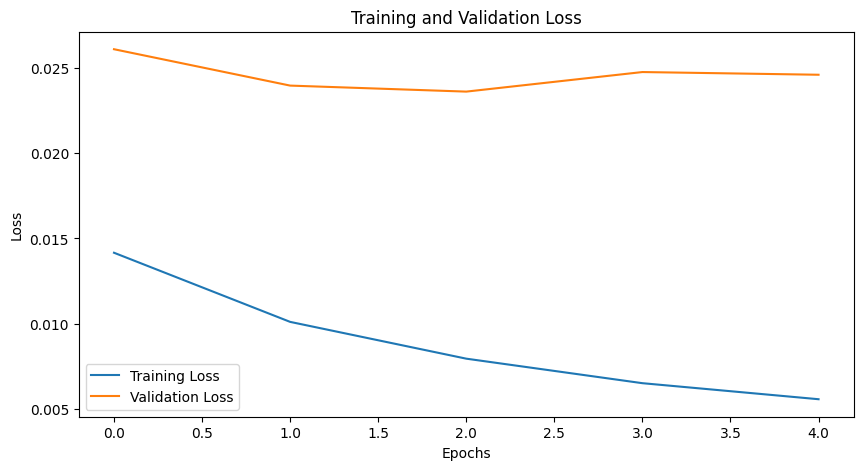

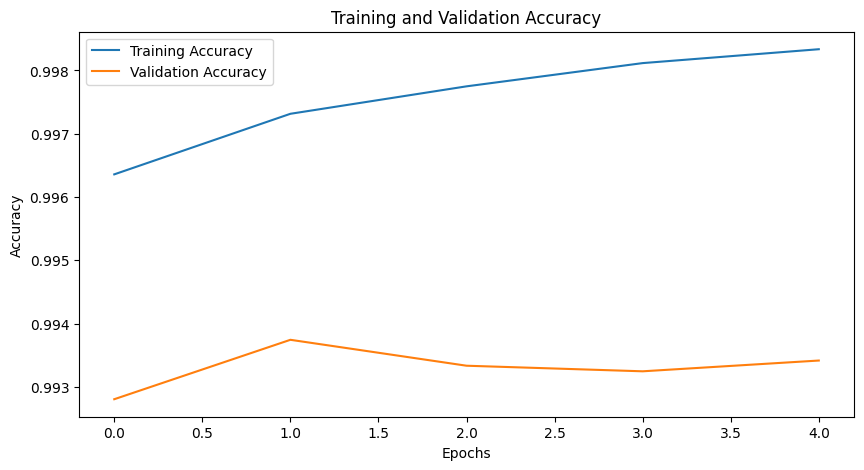

In [44]:
import matplotlib.pyplot as plt

# Fit the model and save the training history
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy if available
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [38]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

44/44 [==============================] - 1s 26ms/step - loss: 0.0293 - accuracy: 0.9919
Test loss: 0.029332222416996956, Test accuracy: 0.9919126033782959


In [43]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

# Assuming 'model' and 'tok' are already loaded and configured
# Assuming 'max_len' and 'tag2idx' are known from your model's training data
# Reverse tag dictionary to map indices to tags
idx2tag = {i: w for w, i in tag2idx.items()}

def preprocess_sentence(sentences, tokenizer, max_len):
    # Tokenize and pad sentences as done with the training data
    seq = tokenizer.texts_to_sequences(sentences)
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    seq_lengths = [len(s) for s in seq]  # Keep track of the original lengths before padding
    return padded_seq, seq_lengths

def decode_predictions(pred, seq_lengths, idx2tag):
    out = []
    for idx, pred_i in enumerate(pred):
        out_i = []
        length = seq_lengths[idx]  # Length of the actual sentence
        for j in range(length):  # Only iterate over the actual sentence length
            p = pred_i[j]
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

# Prepare new sentences for testing
new_sentences = [
    "Facebook and Google are big tech companies.",
    "Barack Obama was the president of the United States.",
    "I love to visit Paris and New York."
]

# Preprocess these new sentences and obtain original lengths
new_X, new_lengths = preprocess_sentence(new_sentences, tok, max_len)

# Predict using the model
predictions = model.predict(new_X)

# Decode predictions to get tag names instead of indices
decoded_predictions = decode_predictions(predictions, new_lengths, idx2tag)

# Print the results
for i, (sent, pred) in enumerate(zip(new_sentences, decoded_predictions)):
    print(f"Sentence {i+1}: {sent}")
    print(f"Predicted tags: {pred}")
    print()


1/1 [==============================] - 0s 35ms/step
Sentence 1: Facebook and Google are big tech companies.
Predicted tags: [1, 0, 3, 0, 0, 7, 0]

Sentence 2: Barack Obama was the president of the United States.
Predicted tags: [1, 2, 0, 0, 0, 0, 0, 3, 6]

Sentence 3: I love to visit Paris and New York.
Predicted tags: [0, 3, 0, 0, 5, 0, 5, 6]

